In [1]:
import api_scraper
api_data = api_scraper.get_water_obs_links()

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import optimize
from scipy.optimize import curve_fit
import numpy as np
from scipy import optimize
import pandas as pd
import dateutil.parser as date_parser
import datetime
import asyncio

In [3]:
sensors = pd.DataFrame(api_data)
sensors

,coords,desc,elev,link,name
0,"[-81.07081, 31.98277]",Skidaway Road at Herb River Sea Level Sensor,2.36,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-031
1,"[-81.084099, 32.085707]",Hutchinson Island environmental sensors,2.8,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-005
2,"[-81.201916, 31.791509]",Kilkenny Creek environmental sensors,2.7,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-004
3,"[-80.959417, 32.034717]",Bull River Marina environmental sensors,2.0,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-011
4,"[-81.153906, 31.935783]",Coffee Bluff Marina environmental sensors,2.4,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-001
5,"[-81.063662, 32.000149]",LaRoche Avenue at Nottingham Creek Sea Level S...,2.38,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-032
6,"[-81.021504, 31.990396]",Skidaway Dock environmental sensors,3.103,https://api.sealevelsensors.org/v1.0/Datastrea...,esp32-rn2903-scott-01
7,"[-80.866956, 32.006419]",Catalina Drive environmental sensors,2.23,https://api.sealevelsensors.org/v1.0/Datastrea...,esp32-rn2903-04
8,"[-81.08402, 31.92835]",Faye Drive on Burnside Island Sea Level Sensor,3.66,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-041
9,"[-80.962163, 32.018171]",Walthour Road environmental sensors,2.83,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-009


In [48]:
def sinx_plus_sinxhalf(x, amp1, amp2, periodicity, xshift, yshift):
    return (amp1 * np.sin(periodicity * (x + xshift))) + (amp2 * np.sin(periodicity / 2 * (x + xshift))) + yshift

#current_date is a datetime object
def get_train_test(sensor, date, train_delta = 8, test_delta = 1):
    link      = sensor["link"]
    elevation = sensor["elev"]
    
    eight_days = datetime.timedelta(days=train_delta)
    one_day    = datetime.timedelta(days=test_delta)
    
    start_date_train = (date - eight_days).isoformat() + "Z"
    end_date_train   = (date - one_day).isoformat() + "Z"
    start_date_test  = (date - one_day).isoformat() + "Z"
    end_date_test    = (date).isoformat() + "Z"
    
    train              = api_scraper.get_obs_for_link(link, start_date_train, end_date_train)
    train              = pd.DataFrame(train, columns=["value", "timestamp"])
    elevation_adjuster = lambda value: float(elevation) + float(value)
    train["adj_value"] = train["value"].map(elevation_adjuster)
    train              = train.drop(columns=["value"])

    test              = api_scraper.get_obs_for_link(link, start_date_test, end_date_test)
    test              = pd.DataFrame(test, columns= ["value", "timestamp"])
    test["adj_value"] = test["value"].map(elevation_adjuster)
    test              = test.drop(columns=["value"])
    
    return train, test 

def fit_curve(train, curve_equation=sinx_plus_sinxhalf, verbose=False):
    xdata_train = train["timestamp"].apply(mdates.date2num)
    ydata_train = train["adj_value"]

    guess_amplitude   = 0.8
    guess_amplitude2  = 0.1
    guess_periodicity = 12.2
    guess_xshift      = 7
    guess_yshift      = 0.1

    guesses = [guess_amplitude, guess_amplitude2, guess_periodicity, guess_xshift, guess_yshift]

    params, params_covariance = optimize.curve_fit(curve_equation,
                                                   xdata_train,
                                                   ydata_train,
                                                   p0 = guesses)

    if verbose:
        plt.figure(figsize=(30, 20))
        plt.scatter(xdata_train, ydata_train, color = "red", label='Data')
        plt.plot(xdata_train, curve_equation(xdata_train, *guesses),
                 label='Guess')
        plt.plot(xdata_train, curve_equation(xdata_train, *params),
                 label='Fitted function')
        plt.legend(loc='best')
        
    return params, calculate_residuals(train, params)

def calculate_residuals(data, params, curve_equation=sinx_plus_sinxhalf, verbose=False, scale_factor=1000):
    xdata             = data["timestamp"].apply(mdates.date2num)
    estimated_y       = curve_equation(xdata, *params)
    
    if verbose:
        plt.figure(figsize=(30, 20))
        plt.scatter(xdata, data["adj_value"], color = "red", label='Data')
        plt.plot(xdata, estimated_y, label='Fitted function')
        plt.legend(loc='best')
        
    squared_residuals = (estimated_y - data["adj_value"]) ** 2
    return np.mean(squared_residuals) * scale_factor

def full_test(sensor, date=datetime.datetime.now(), verbose=False):
    try:
        train, test = get_train_test(sensor, date)
        params, train_residuals = fit_curve(train, verbose=verbose)
        return train_residuals, calculate_residuals(test, params, verbose=verbose)
    except:
        print("ERROR")
        print(sensor)
        return None

In [49]:
residuals                  = sensors.apply(full_test, axis=1)
train_residuals            = residuals.apply(lambda res: res[0] if res else None)
test_residuals             = residuals.apply(lambda res: res[1] if res else None)
sensors["train_residuals"] = train_residuals
sensors["test_residuals"]  = test_residuals

ERROR
coords                                       [-81.021504, 31.990396]
desc                             Skidaway Dock environmental sensors
elev                                                           3.103
link               https://api.sealevelsensors.org/v1.0/Datastrea...
name                                           esp32-rn2903-scott-01
train_residuals                                                  NaN
test_residuals                                                   NaN
Name: 6, dtype: object
ERROR
coords                                       [-80.866956, 32.006419]
desc                            Catalina Drive environmental sensors
elev                                                            2.23
link               https://api.sealevelsensors.org/v1.0/Datastrea...
name                                                 esp32-rn2903-04
train_residuals                                                  NaN
test_residuals                                                   NaN

In [50]:
sensors

,coords,desc,elev,link,name,train_residuals,test_residuals
0,"[-81.07081, 31.98277]",Skidaway Road at Herb River Sea Level Sensor,2.36,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-031,19.738388,4.072604
1,"[-81.084099, 32.085707]",Hutchinson Island environmental sensors,2.8,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-005,28.958796,32.482683
2,"[-81.201916, 31.791509]",Kilkenny Creek environmental sensors,2.7,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-004,39.397484,54.208216
3,"[-80.959417, 32.034717]",Bull River Marina environmental sensors,2.0,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-011,25.544836,36.005540
4,"[-81.153906, 31.935783]",Coffee Bluff Marina environmental sensors,2.4,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-001,28.610721,44.720271
5,"[-81.063662, 32.000149]",LaRoche Avenue at Nottingham Creek Sea Level S...,2.38,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-032,25.999945,27.304557
6,"[-81.021504, 31.990396]",Skidaway Dock environmental sensors,3.103,https://api.sealevelsensors.org/v1.0/Datastrea...,esp32-rn2903-scott-01,NaN,NaN
7,"[-80.866956, 32.006419]",Catalina Drive environmental sensors,2.23,https://api.sealevelsensors.org/v1.0/Datastrea...,esp32-rn2903-04,NaN,NaN
8,"[-81.08402, 31.92835]",Faye Drive on Burnside Island Sea Level Sensor,3.66,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-041,33.089158,45.191598
9,"[-80.962163, 32.018171]",Walthour Road environmental sensors,2.83,https://api.sealevelsensors.org/v1.0/Datastrea...,gt-envsense-009,31.103264,35.524494


(30.69459663999139, 51.26707795058175)

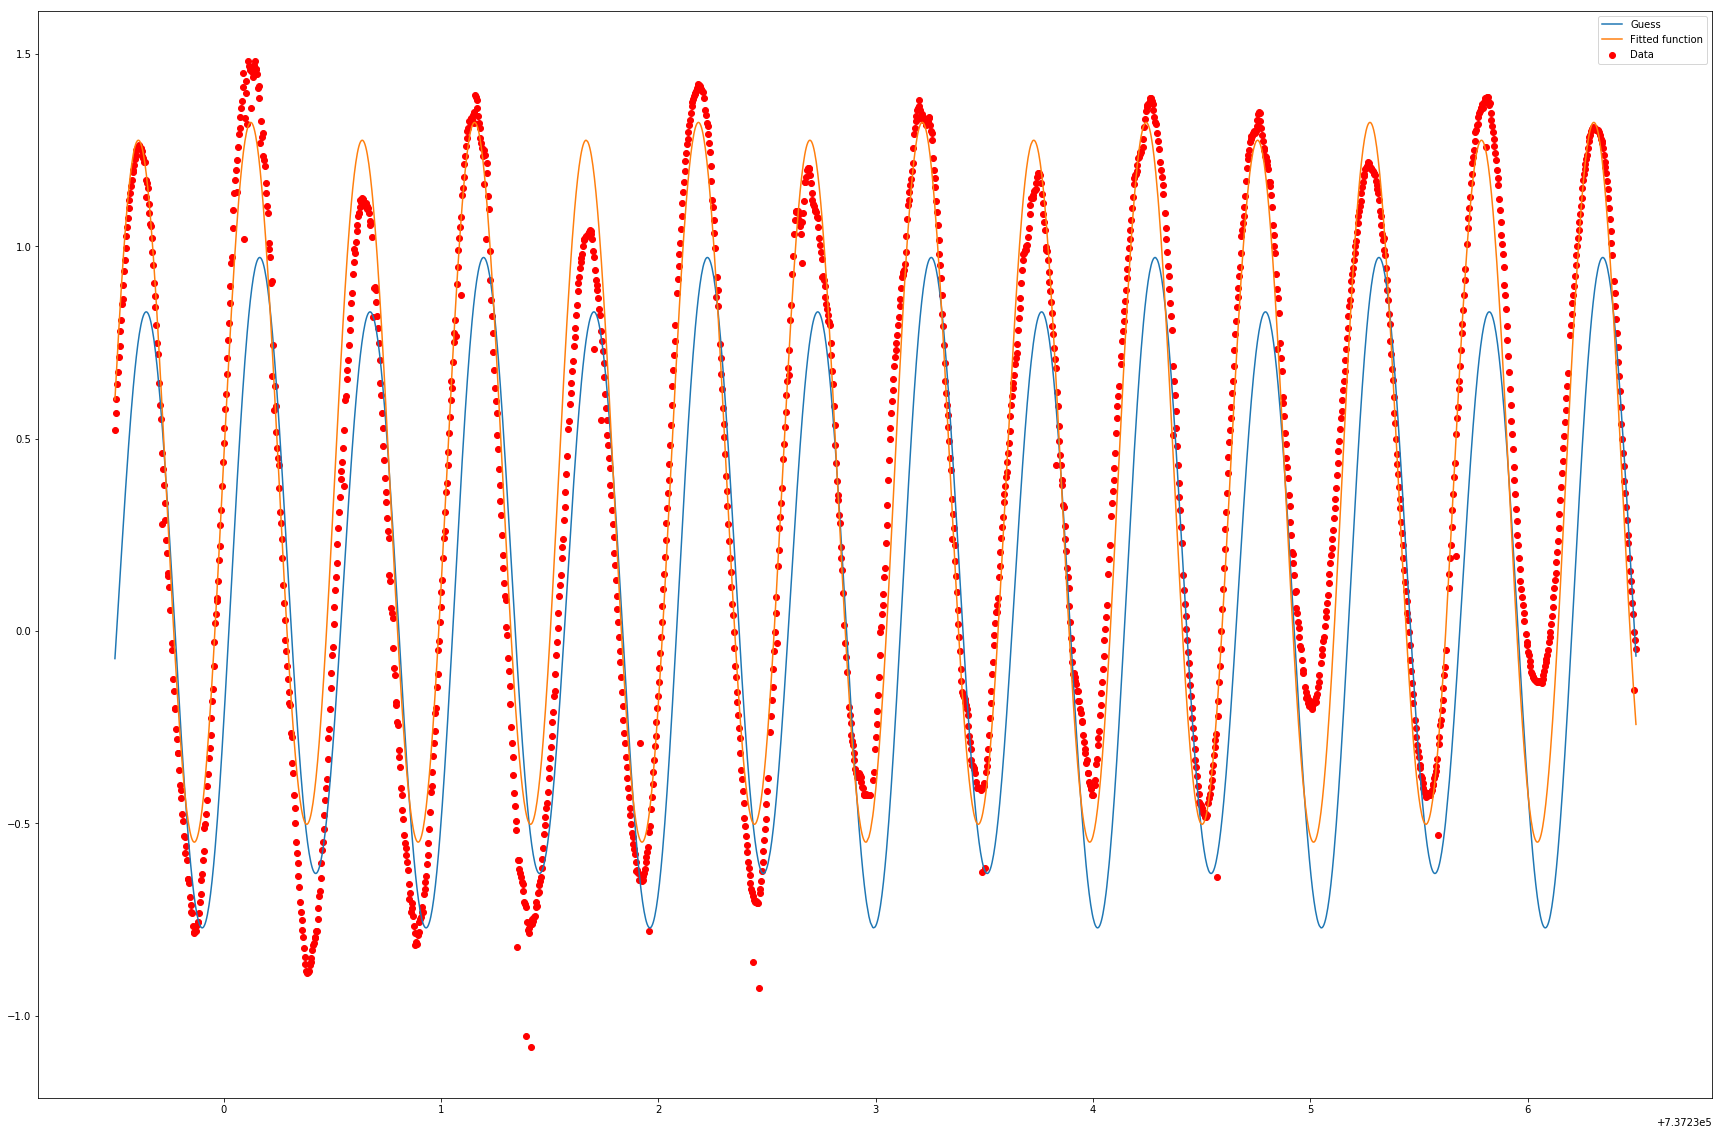

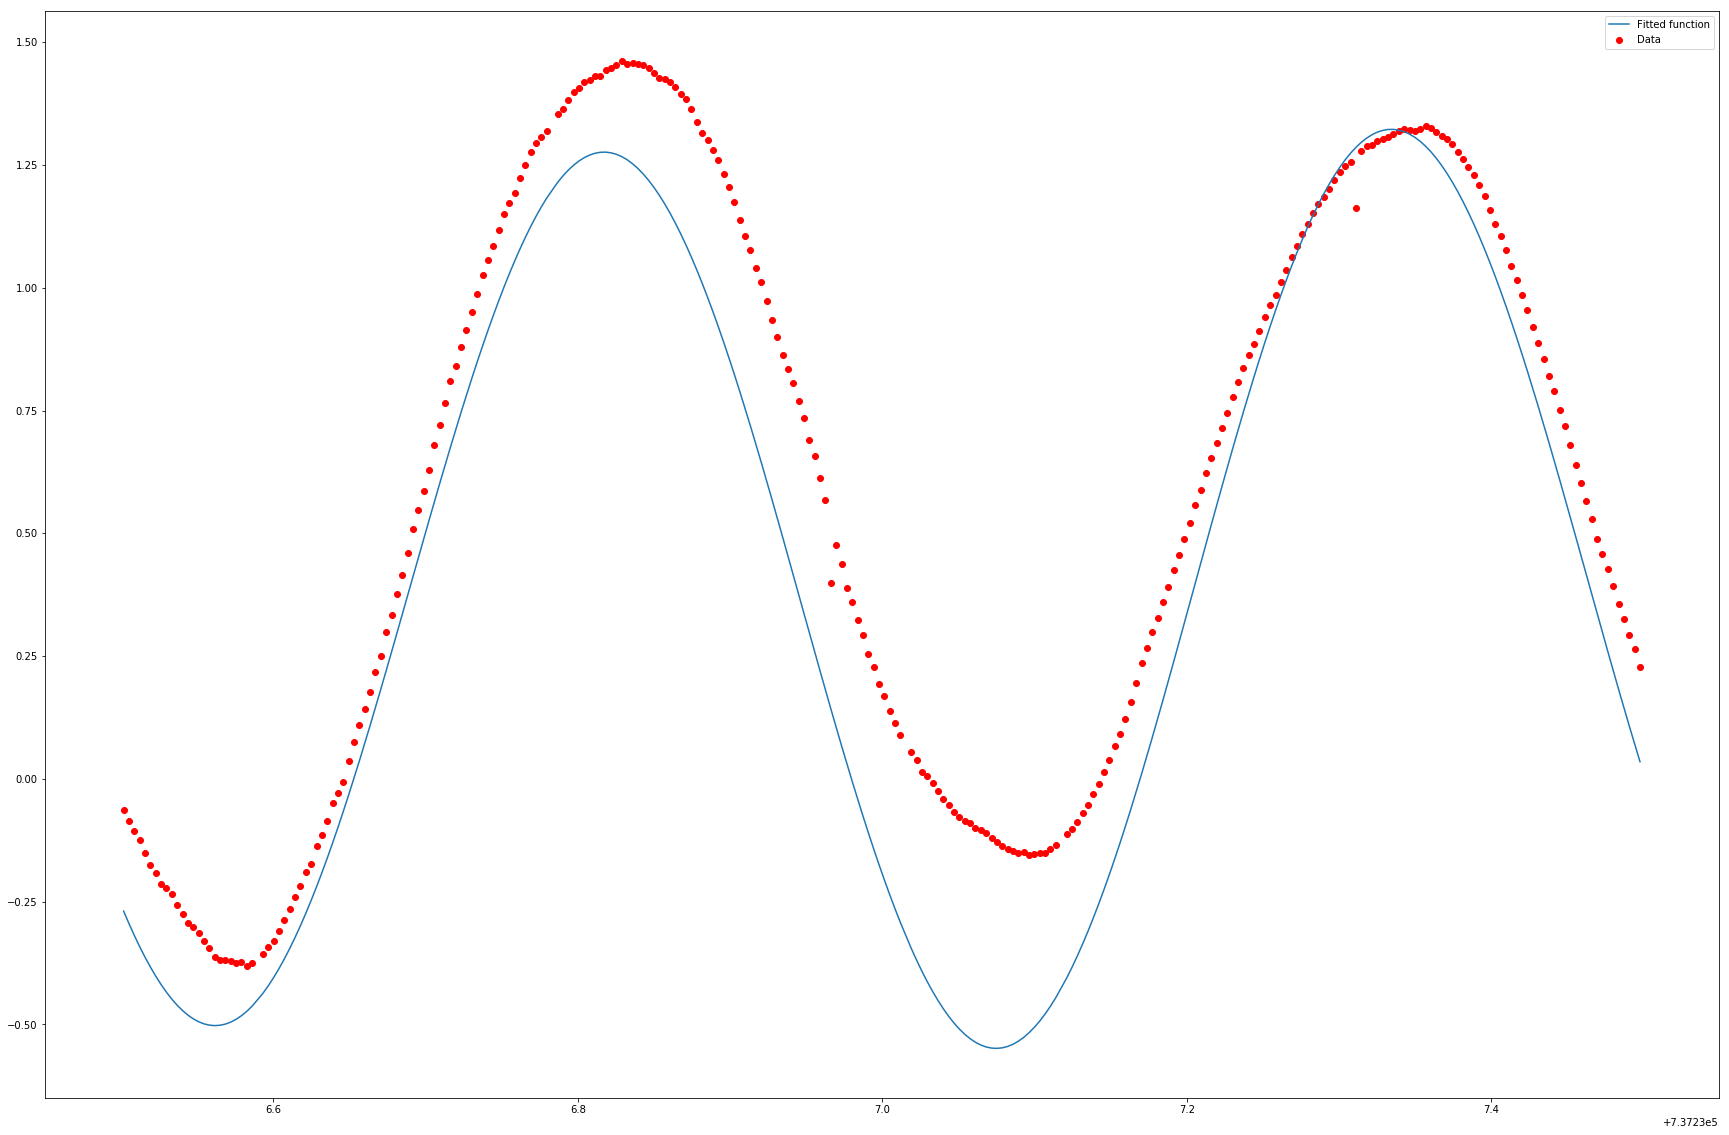

In [53]:
sensor = sensors.loc[14]
full_test(sensor, verbose=True)